# Taming Transformers

This notebook is a minimal working example to generate landscape images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers). **tl;dr** We combine the efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.

## Setup
The setup code in this section was written to be [run in a Colab environment](https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/taming-transformers.ipynb). For a full, local setup, we recommend the provided [conda environment](https://github.com/CompVis/taming-transformers/blob/master/environment.yaml), as [described in the readme](https://github.com/CompVis/taming-transformers#requirements). This will also allow you to run a streamlit based demo.

Here, we first clone the repository and download a model checkpoint and config.

In [2]:
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers

fatal: destination path 'taming-transformers' already exists and is not an empty directory.
/content/taming-transformers


Next, we install minimal required dependencies.

In [2]:
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops transformers
%pip install torch-summary # !!! Necessary to install, need to restart kernel after install
import sys
sys.path.append(".")

Import all the following libraries.

In [3]:
import io
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import os, sys
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import requests
import torch
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import yaml

from taming.models.vqgan import VQModel, GumbelVQ

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## Loading the model

Download the model.

In [4]:
!mkdir ./model
!mkdir ./model/checkpoint
!mkdir ./model/config

# !wget 'https://storage.googleapis.com/yes-ai-taming-transformer/cin_transformer.ckpt' -O './model/checkpoint/cin_transformer.ckpt'
# !wget 'https://storage.googleapis.com/yes-ai-taming-transformer/cin_transformer.yaml' -O './model/config/cin_transformer.yaml'
!wget 'https://heibox.uni-heidelberg.de/f/34a747d5765840b5a99d/?dl=1' -O './model/checkpoint/vqgan_gumbel_f8.ckpt'
!wget 'https://heibox.uni-heidelberg.de/f/b24d14998a8d4f19a34f/?dl=1' -O './model/config/vqgan_gumbel_f8.yaml' 

In [5]:
# ckpt_path = "model/checkpoint/cin_transformer.ckpt"
# config_path = "configs/imagenet_vqgan.yaml"
ckpt_path = './model/checkpoint/vqgan_gumbel_f8.ckpt'
config_path = './model/config/vqgan_gumbel_f8.yaml'

Load the config and model.

In [6]:
def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model

Print config file.

In [7]:
config_cin = load_config(config_path, display=True)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 32
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    kl_weight: 1.0e-08
    lossconfig:
      target: taming.modules.losses.vqperceptual.DummyLoss
    monitor: val/rec_loss
    n_embed: 8192
    temperature_scheduler_config:
      params:
        lr_max: 0.9
        lr_min: 1.0e-06
        lr_start: 0.9
        max_decay_steps: 1000001
        warm_up_steps: 0
      target: taming.lr_scheduler.LambdaWarmUpCosineScheduler
  target: taming.models.vqgan.GumbelVQ



Print model summary.

In [8]:
model_cin = load_vqgan(config_cin, ckpt_path=ckpt_path, is_gumbel=True).to(DEVICE)
model_cin.eval() # set to evaluation mode
summary(model_cin, [3, 256, 256])

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 256, 32, 32]         --
|    └─Conv2d: 2-1                       [-1, 128, 256, 256]       3,584
|    └─Module: 2                         []                        --
|    |    └─ResnetBlock: 3-1             [-1, 512, 32, 32]         4,721,664
|    |    └─AttnBlock: 3-2               [-1, 512, 32, 32]         1,051,648
|    |    └─ResnetBlock: 3-3             [-1, 512, 32, 32]         4,721,664
|    └─GroupNorm: 2-2                    [-1, 512, 32, 32]         1,024
|    └─Conv2d: 2-3                       [-1, 256, 32, 32]         1,179,904
├─Conv2d: 1-2                            [-1, 256, 32, 32]         65,792
├─GumbelQuantize: 1-3                    [-1, 256, 32, 32]         --
|    └─Conv2d: 2-4                       [-1, 8192, 32, 32]        2,105,344
├─Conv2d: 1-4                            [-1, 25

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1-1                           [-1, 256, 32, 32]         --
|    └─Conv2d: 2-1                       [-1, 128, 256, 256]       3,584
|    └─Module: 2                         []                        --
|    |    └─ResnetBlock: 3-1             [-1, 512, 32, 32]         4,721,664
|    |    └─AttnBlock: 3-2               [-1, 512, 32, 32]         1,051,648
|    |    └─ResnetBlock: 3-3             [-1, 512, 32, 32]         4,721,664
|    └─GroupNorm: 2-2                    [-1, 512, 32, 32]         1,024
|    └─Conv2d: 2-3                       [-1, 256, 32, 32]         1,179,904
├─Conv2d: 1-2                            [-1, 256, 32, 32]         65,792
├─GumbelQuantize: 1-3                    [-1, 256, 32, 32]         --
|    └─Conv2d: 2-4                       [-1, 8192, 32, 32]        2,105,344
├─Conv2d: 1-4                            [-1, 256, 32, 32]         65,792
├─Decoder: 1-5                      

## First stage model

Try some reconstruction of images.

In [9]:
def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        print("Warning: current_image_size < target_image_size, image will be resized and may lose resolution")
        img.resize((target_image_size, target_image_size))
        # raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    image = PIL.Image.open(io.BytesIO(resp.content))
    return image

def read_image(path):
    image = PIL.Image.open(path)
    return image

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

Load an example data.

torch.Size([3, 512, 512])


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


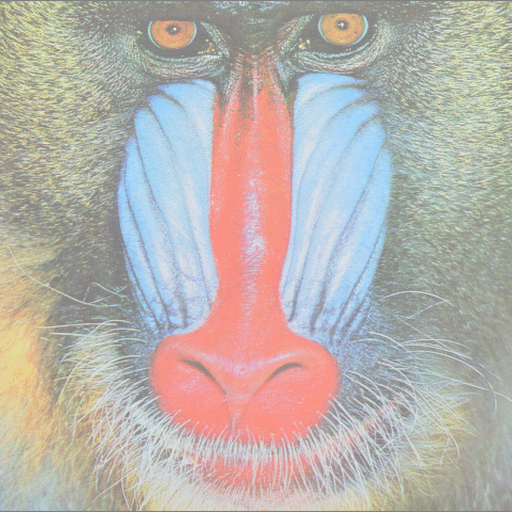

In [10]:
# image = download_image('https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1')
image = read_image('data/super-resolution/HR/img_001_HR.png')
image = preprocess(image, target_image_size=512)

print(image[0].shape)
custom_to_pil(image[0])

In [11]:
x_vqgan = preprocess_vqgan(image)

Our model also employs a VQGAN for the conditioning information, i.e. the segmentation in this example. Let's autoencode the segmentation map. Encoding returns both the quantized code and its representation in terms of indices of a learned codebook.

In [12]:
def stack_images(input, x, titles=[]):
  print(input.size)
  assert input.shape == x.shape
  w, h = input.shape[1], input.shape[2]
  print(w,h)
  img = Image.new("RGB", (2*w, h))
  img.paste(input, (0,0))
  img.paste(x, (w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255), font=ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf", 22)
) # coordinates, text, color, font
  return img

VQGAN --- GumbelVQ: latent shape: torch.Size([64, 64])
torch.Size([3, 512, 512])


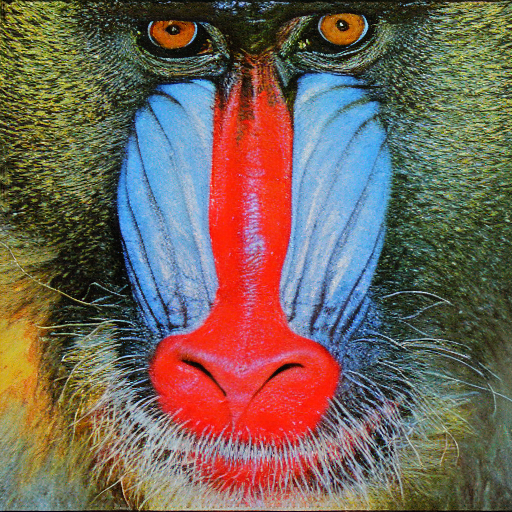

In [13]:
x_new = reconstruct_with_vqgan(x_vqgan.to(DEVICE), model_cin)
print(x_new[0].shape)
custom_to_pil(x_new[0])

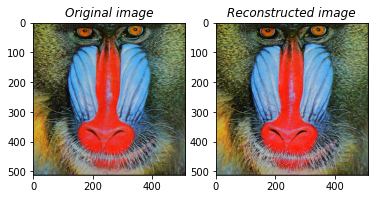

In [15]:
def post_process(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  return x

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(post_process(x_vqgan[0]))
ax1.set_title('Original image', fontstyle='italic')
ax2.imshow(post_process(x_new[0]))
ax2.set_title('Reconstructed image', fontstyle='italic')

fig.savefig('results/reconstruction.png')